- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats

from recommenderSystem import RecSys

# Datios Intelia

Se pueden realizar pruebas con cualquier compañía pero me gustaría empezar por la 23 y 15.

In [2]:
!ls data

customers.csv  products.csv  relation.csv


In [3]:
dataPath = "data/"

df_intelia_users = pd.read_csv(dataPath + "customers.csv")
df_intelia_items = pd.read_csv(dataPath + "products.csv")
df_intelia_pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_510/1378237331.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_510/1378237331.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_items = pd.read_csv(dataPath + "products.csv")


In [4]:
df_intelia_pairs.sample(3)

,company_id,product_id,customer_id,compras,visto,peso,ultimo
265818,36,120773,199350,1,0,3.00,2017-02-08 20:47:08
53070,15,28894,230286,0,2,0.04,2022-06-22 16:47:57
269714,36,121023,207490,1,0,3.00,2018-03-11 11:04:35


# Formula peso

El número de visitas es usado en una funcion racional de rango 0 a 1 para los valores positivos

$$
PesoVisita = \frac{1 * visitas}{visitas + 5}
$$

0 --> 0.0
1 --> 0.16666666666666666
2 --> 0.2857142857142857
3 --> 0.375
4 --> 0.4444444444444444
5 --> 0.5
6 --> 0.5454545454545454
7 --> 0.5833333333333334
8 --> 0.6153846153846154
9 --> 0.6428571428571429
10 --> 0.6666666666666666
15 --> 0.75
20 --> 0.8
25 --> 0.8333333333333334
30 --> 0.8571428571428571
40 --> 0.8888888888888888
50 --> 0.9090909090909091
75 --> 0.9375
100 --> 0.9523809523809523
200 --> 0.975609756097561
500 --> 0.9900990099009901
1000 --> 0.9950248756218906
10000 --> 0.9995002498750625


<AxesSubplot:ylabel='Frequency'>

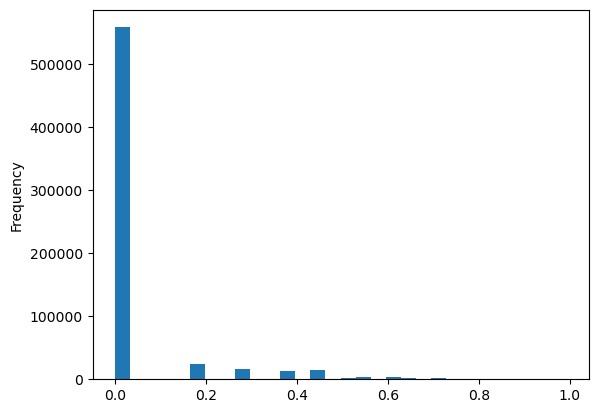

In [5]:
def funcRac_range1_pendiente3(x):
    return (1 * x) / (x + 5)

for x in [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100,200,500,1000,10000]:
    print(x, "-->", funcRac_range1_pendiente3(x))
    
df_intelia_pairs["peso_visita"] = df_intelia_pairs.visto.apply(funcRac_range1_pendiente3)
df_intelia_pairs["peso_visita"].plot.hist(bins=30)

Se necesitan los valores entre una rango determinado

El número de compras es usado en una funcion racional de rango 0 a 5 para los valores positivos

$$
Peso = \frac{5 * (compras+PesoVisita)}{(compras+PesoVisita) + 1}
$$

0 --> 0.0
1 --> 2.5
2 --> 3.3333333333333335
3 --> 3.75
4 --> 4.0
5 --> 4.166666666666667
6 --> 4.285714285714286
7 --> 4.375
8 --> 4.444444444444445
9 --> 4.5
10 --> 4.545454545454546
15 --> 4.6875
20 --> 4.761904761904762
25 --> 4.8076923076923075
30 --> 4.838709677419355
40 --> 4.878048780487805
50 --> 4.901960784313726
75 --> 4.934210526315789
100 --> 4.9504950495049505
200 --> 4.975124378109452
500 --> 4.990019960079841
1000 --> 4.995004995004995
10000 --> 4.999500049995


<AxesSubplot:ylabel='Frequency'>

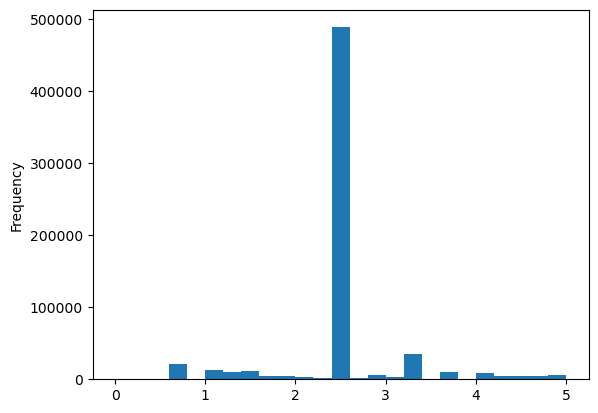

In [6]:
def funcRac_range5_pendiente3(x):
    return (5 * x) / (x + 1)

for x in [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100,200,500,1000,10000]:
    print(x, "-->", funcRac_range5_pendiente3(x))
    
df_intelia_pairs["peso"] = (df_intelia_pairs.compras + df_intelia_pairs.peso_visita).apply(funcRac_range5_pendiente3)
df_intelia_pairs["peso"].plot.hist(bins=25)

## No hay duplicados

In [7]:
df_intelia_pairs [ df_intelia_pairs[["company_id", "product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,compras,visto,peso,ultimo,peso_visita


In [8]:
df_intelia_pairs [ df_intelia_pairs[["product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,compras,visto,peso,ultimo,peso_visita


# Compañias
Se pueden realizar pruebas con cualquier compañía pero me gustaría empezar por la 23 y 15.

In [9]:
df_intelia_pairs.groupby(['company_id']).size().sort_values(ascending=False)

company_id
39    353494
23     89252
15     60226
21     24037
24     23551
14     19459
16     16908
1      15204
36     13627
13      9080
6       5775
40      4950
12      1862
33      1833
3        847
29       663
10       558
5        451
35       294
31       201
9        112
32       106
19        44
7         41
30        30
8         25
34        14
4          5
44         4
18         3
47         1
dtype: int64

In [10]:
company_ids = df_intelia_pairs.company_id.unique() #.tolist()
company_ids

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       23, 24, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 44, 47])

In [11]:
def get_dfs_company(comp_id):
    return df_intelia_pairs[ df_intelia_pairs.company_id == comp_id], \
           df_intelia_users[ df_intelia_users.company_id == comp_id], \
           df_intelia_items[ df_intelia_items.company_id == comp_id]

# Otras compañias



COMPAÑÍA: 1
Number of users: 316
Number of items: 297
Number of interactions: 15204


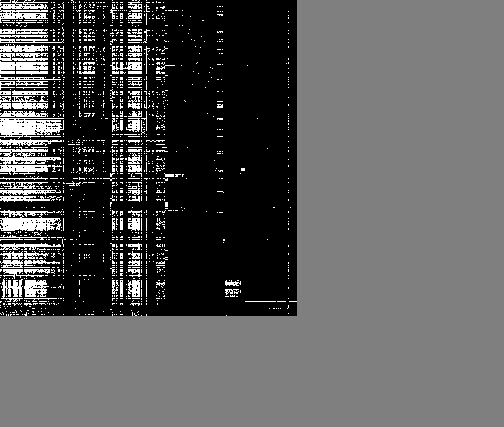

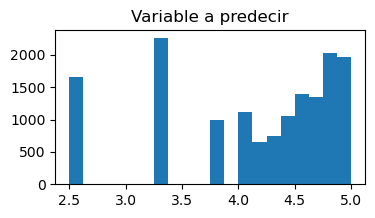



COMPAÑÍA: 3
Number of users: 384
Number of items: 65
Number of interactions: 847


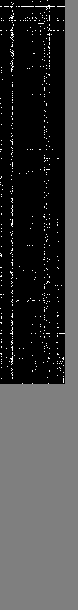

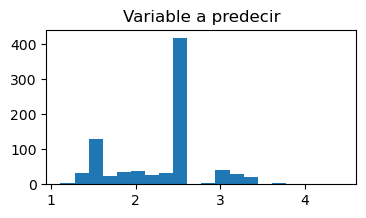



COMPAÑÍA: 4
Number of users: 2
Number of items: 3
Number of interactions: 5


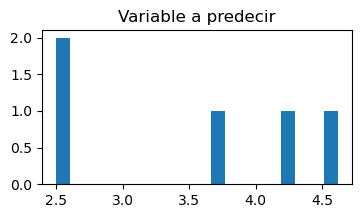



COMPAÑÍA: 5
Number of users: 27
Number of items: 111
Number of interactions: 451


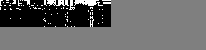

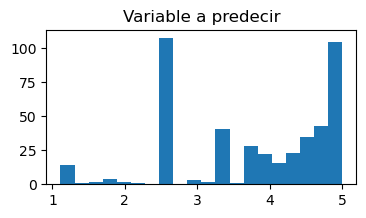



COMPAÑÍA: 6
Number of users: 265
Number of items: 783
Number of interactions: 5775


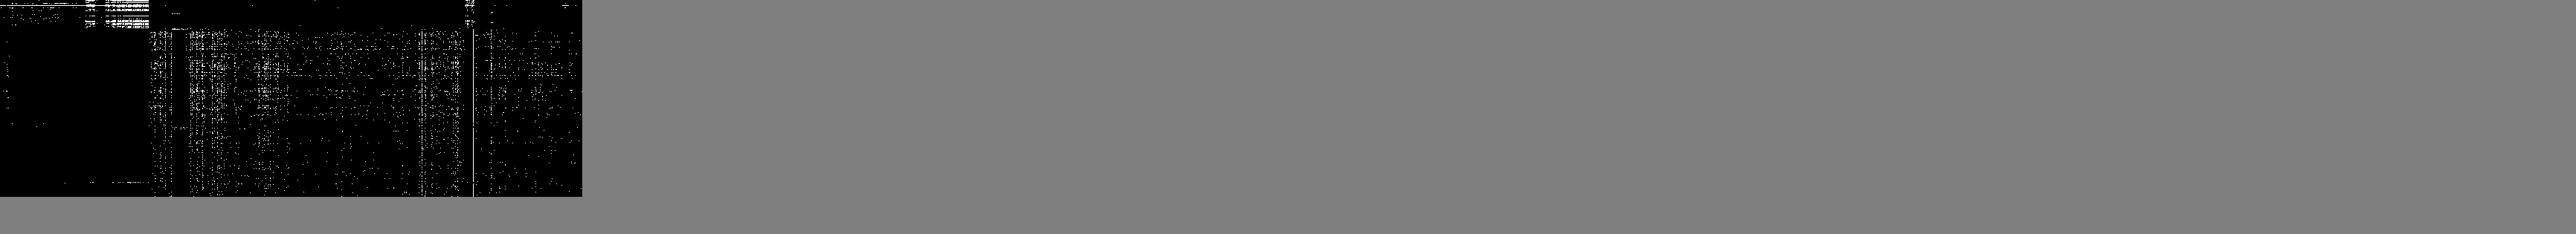

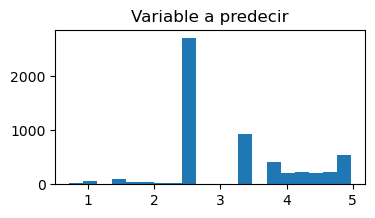



COMPAÑÍA: 7
Number of users: 6
Number of items: 34
Number of interactions: 41


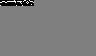

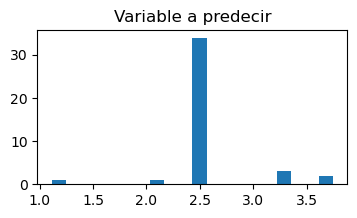



COMPAÑÍA: 8
Number of users: 5
Number of items: 21
Number of interactions: 25


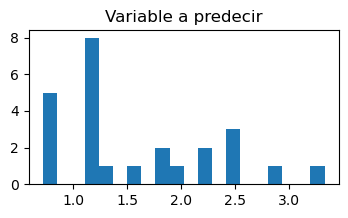



COMPAÑÍA: 9
Number of users: 8
Number of items: 94
Number of interactions: 112


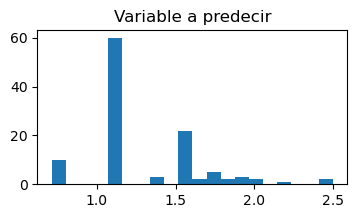



COMPAÑÍA: 10
Number of users: 103
Number of items: 128
Number of interactions: 558


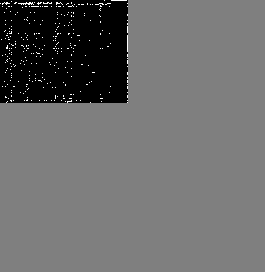

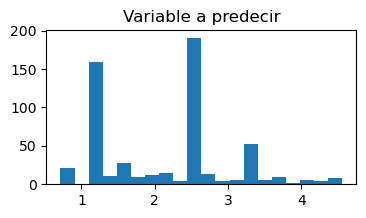



COMPAÑÍA: 12
Number of users: 170
Number of items: 1262
Number of interactions: 1862


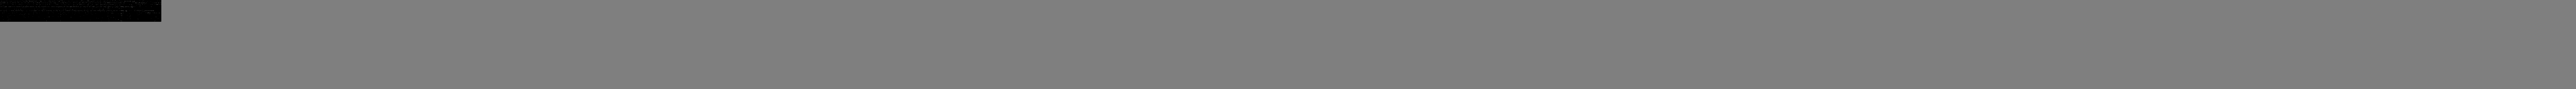

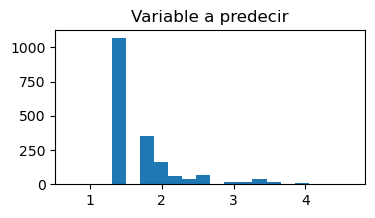



COMPAÑÍA: 18
Number of users: 2
Number of items: 2
Number of interactions: 3


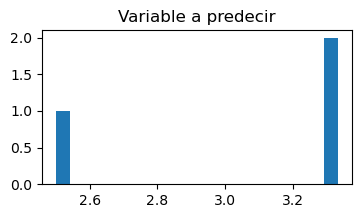



COMPAÑÍA: 19
Number of users: 5
Number of items: 33
Number of interactions: 44


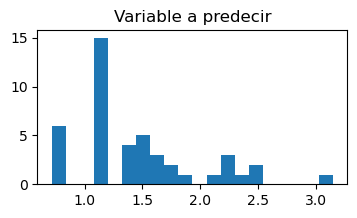



COMPAÑÍA: 29
Number of users: 467
Number of items: 39
Number of interactions: 663


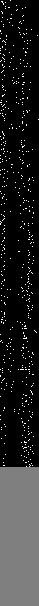

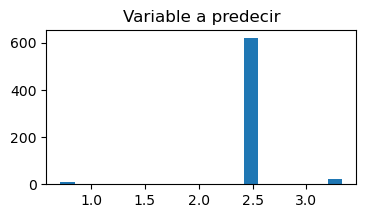



COMPAÑÍA: 30
Number of users: 1
Number of items: 30
Number of interactions: 30


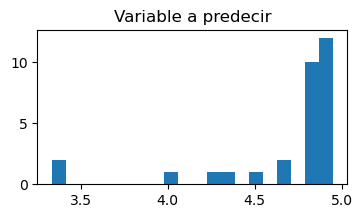



COMPAÑÍA: 31
Number of users: 86
Number of items: 23
Number of interactions: 201


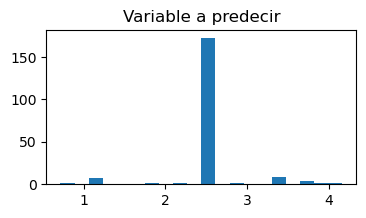



COMPAÑÍA: 32
Number of users: 30
Number of items: 18
Number of interactions: 106


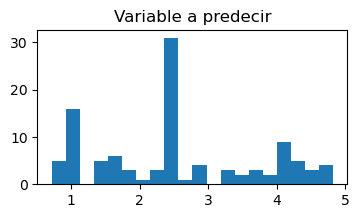



COMPAÑÍA: 34
Number of users: 8
Number of items: 13
Number of interactions: 14


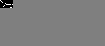

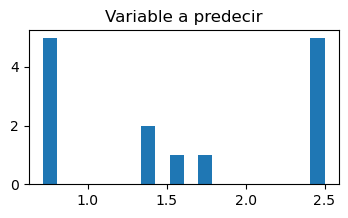



COMPAÑÍA: 35
Number of users: 46
Number of items: 50
Number of interactions: 294


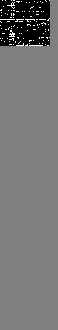

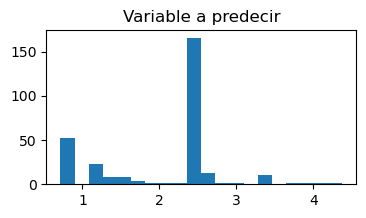



COMPAÑÍA: 44
Number of users: 1
Number of items: 4
Number of interactions: 4


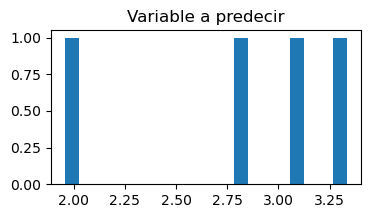

In [14]:
for comp_id in [1,3,4,5,6,7,8,9,10,12,18,19,29,30,31,32,34,35,44]:
    print("\n\nCOMPAÑÍA:", comp_id)
    rs = RecSys(*get_dfs_company(comp_id), userName="customer_id", itemName="product_id", scoreName="peso")
    rs.draw_matrix()